In [2]:
import os
from PIL import Image
import hashlib

def image_to_byte_array(image):
    img_byte_array = bytearray()
    img_byte_array.extend(image.tobytes())
    return bytes(img_byte_array)

def remove_duplicates(source_folder, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    # Dictionary to store the hash values of images
    hash_dict = {}

    # Iterate through each image file in the source folder
    for filename in os.listdir(source_folder):
        filepath = os.path.join(source_folder, filename)
        if os.path.isfile(filepath):
            # Open the image file and convert it to bytes
            img = Image.open(filepath)
            img_bytes = image_to_byte_array(img)

            # Calculate the MD5 hash value of the image bytes
            img_hash = hashlib.md5(img_bytes).hexdigest()

            # Check if the hash value already exists in the dictionary
            if img_hash not in hash_dict:
                # If not, copy the image to the destination folder
                img.save(os.path.join(destination_folder, filename))
                
                # Store the hash value in the dictionary
                hash_dict[img_hash] = filename
            
# Specify the source folder containing the images
source_folder = 'E7-images'

# Specify the destination folder for storing cleaned images
destination_folder = 'E7-unique-images'

# Call the function to remove duplicates
remove_duplicates(source_folder, destination_folder)
number_of_images = len(os.listdir(destination_folder))
print(number_of_images)


173


In [3]:
def extract_features(contours):
    features = []
    for contour in contours:
        # Minimum area rectangle
        rect = cv2.minAreaRect(contour) #tight-fitting box
            
        # Box coordinates
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        tight_fitting_boxes.append(box)
            
        # Calculate dimensions
        dim1 = np.linalg.norm(box[0] - box[1])
        dim2 = np.linalg.norm(box[1] - box[2])
            
        dim_1.append(dim1)
        dim_2.append(dim2)
        # Calculate contour area
        contour_area = cv2.contourArea(contour)
        contour_areas.append(contour_area)
            
        # Calculate layout area
        tight_fit_box_area = dim1 * dim2
        tight_fit_box_areas.append(tight_fit_box_area)
            
        # Draw tight-fitting box and contours on the image (for visualization)
        cv2.drawContours(original_image, [box], 0, (0, 255, 0), 2)  # Tight-fitting box
        cv2.drawContours(original_image, [contour], 0, (255, 0, 0), 2)  # Contour
        
        
        # Number of vertices
        num_vertices = len(contour)
        
        # Perimeter
        perimeter = cv2.arcLength(contour, True)
        
        p_a = perimeter / contour_area

        circularity = (4 * np.pi * contour_area) / (perimeter ** 2)
        
        # Angle changes
        angles = []
        for i in range(num_vertices):
            p1 = contour[i][0]
            p2 = contour[(i + 1) % num_vertices][0]
            p3 = contour[(i + 2) % num_vertices][0]
            v1 = np.array(p1) - np.array(p2)
            v2 = np.array(p3) - np.array(p2)
            angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angles.append(np.degrees(angle))
        
        # Minimum, maximum, and mean angle changes
        min_angle_change = np.min(angles)
        max_angle_change = np.max(angles)
        mean_angle_change = np.mean(angles)
        
        # Ratio of area of contour to tight bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        bounding_rect_area = w * h
        ratio_area_to_bounding_rect = contour_area / bounding_rect_area

        M = cv2.moments(contour)
        cx = int(M['m10'] / M['m00'])  # Centroid x
        cy = int(M['m01'] / M['m00'])  # Centroid y
        distances = [np.sqrt((point[0][0] - cx) ** 2 + (point[0][1] - cy) ** 2) for point in contour]
        avg_distance_from_centroid = np.mean(distances)
        symmetry = perimeter / avg_distance_from_centroid

        laplacian = cv2.Laplacian(image, cv2.CV_64F)
        gradient_magnitude = np.mean(np.abs(laplacian))
        
        features.append([num_vertices, perimeter, contour_area, p_a, circularity, min_angle_change,max_angle_change, mean_angle_change , dim1, dim2, ratio_area_to_bounding_rect, symmetry, gradient_magnitude])
    
    return features


   


In [4]:
import cv2 #cv2 stands for opencv : opensource computer vision and ml library
import numpy as np
import os #interacting with operating system- to do things like we use command line for accessing and manipulating files
import csv
import pandas as pd
from sklearn.cluster import KMeans
from shutil import copyfile

# Path to the folder containing your images
folder_path = "E7-unique-images"

tfimage_folder = "E7-tfimages"
os.makedirs(tfimage_folder, exist_ok=True)

# Initialize lists to store results
images =[]
tight_fitting_boxes = []
contour_areas = []
tight_fit_box_areas = []
dim_1=[]
dim_2=[]
features_list=[]

processed_images=0

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (JPG OR JPEG or PNG)
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"): #so that we don't run into a situation where we are doing imge kund operations on some non-image files
        # Construct the full path to the image file
        img_path = os.path.join(folder_path, filename)
        
        # Load image
        image = cv2.imread(img_path) #reading specific image file
        images.append(image)
        original_image = image.copy()  # Save a copy for visualization
        
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #conversion flag- cv2.COLOR_BGR2GRAY
        
        # Threshold the image to create a mask of colored areas 
        #threshhold fn gives threshold value and thresholded image as output.
        _, masked_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV) 
        # 200 is our threshold value. pixels above 200 get conv into 255(W) and rest into 0(B): then through binary inversion fn they are inverted -- swaped.

        # Find contours 
        #findContours function gives contours and their heirarchies
        contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
        #cv2.RETR_EXTERNAL ignores any internal contours that exist. 
        #cv2.CHAIN_APPROX_SIMPLE is contour approximation method- compresses horizontal, vertical, and diagonal segments and leaves only their end points.
        
        extractedfeatures=extract_features(contours)
        for features in extractedfeatures:
            features.insert(0, filename)
        # Write processed image to output folder
        output_img_path = os.path.join(tfimage_folder, filename)
        cv2.imwrite(output_img_path, original_image)
        
        # Increment the counter
        processed_images += 1

        features_list.extend(extractedfeatures)
        
# Save features to CSV
csv_file = "features.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file) 
    writer.writerow(["Image Number","Num_Vertices", "Perimeter", "Contour Area","ratio of perimeter and area", "Circularity", "Min_Angle_Change", "Max_Angle_Change", "Mean_Angle_Change", "dim1 of tfb", "dim2 of tfb","Ratio_Area_to_Bounding_Rect", "Symmetry","gradient_magnitude"])
    writer.writerows(features_list)

print("Results saved to:", csv_file)



C:\Users\bpadm\AppData\Local\Temp\ipykernel_8384\942949031.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Results saved to: features.csv


In [5]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from shutil import copyfile

# Read the CSV file
df = pd.read_csv(csv_file)

# Extract features

features = df.iloc[:, 1:].values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
features_pca = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(features_pca, columns=[f"PC{i+1}" for i in range(features_pca.shape[1])])
pca_df.to_csv("pca_transformed_features.csv", index=False)

# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_pca)

# Create folder for clusters
clusters_folder = "4clusterspca"
os.makedirs(clusters_folder, exist_ok=True)

# Create folders for each cluster inside the 'clusters' directory
for cluster_id in range(4):
    cluster_folder = os.path.join(clusters_folder, f"Cluster_{cluster_id}")
    os.makedirs(cluster_folder, exist_ok=True)

# Move images to respective cluster folders
for filename, cluster_id in zip(df['Image Number'], clusters):
    source_path = os.path.join(tfimage_folder, str(filename))  # Convert filename to string
    dest_folder = os.path.join(clusters_folder, f"Cluster_{cluster_id}")
    dest_path = os.path.join(dest_folder, str(filename))  # Convert filename to string
    
    # Check if source file exists before copying
    if os.path.isfile(source_path):
        copyfile(source_path, dest_path)
    

print("Images moved to respective cluster folders.")

# # Move images to respective cluster folders
# for filename, cluster_id in zip(df['Image Number'], clusters):
#     source_path = os.path.join(tfimage_folder, filename)
#     dest_folder = os.path.join(clusters_folder, f"Cluster_{cluster_id}")
#     dest_path = os.path.join(dest_folder, filename)
    
#     # Check if source file exists before copying
#     if os.path.isfile(source_path):
#         copyfile(source_path, dest_path)
#     else:
#         print(f"Source file '{source_path}' does not exist.")

# print("Images moved to respective cluster folders.")

# Access centroids of clusters
centroids = kmeans.cluster_centers_

# Print centroids
print("Centroids of Clusters:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i} Centroid:", centroid)


Images moved to respective cluster folders.
Centroids of Clusters:
Cluster 0 Centroid: [-0.94319453 -0.28930402 -0.20666909 -0.39288937 -0.4522806  -0.01540116]
Cluster 1 Centroid: [ 2.64508546 -1.63155924  0.50412281  0.39741403  0.18662726  0.01804356]
Cluster 2 Centroid: [-3.01506008  0.24535758  0.26869973  0.41264837  0.38532818  0.01698229]
Cluster 3 Centroid: [ 2.33736338  1.50107844 -0.3568276  -0.1314233   0.15509792 -0.00793038]


In [9]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import shutil
from shutil import copyfile

# Step 1: Read the features from the CSV file
features_df = pd.read_csv('features.csv')

# Step 2: Extract the features you mentioned
selected_features = ['ratio of perimeter and area', 'Circularity', 'Min_Angle_Change',
                     'Max_Angle_Change', 'Mean_Angle_Change', 'Ratio_Area_to_Bounding_Rect', 'Symmetry','gradient_magnitude']
X = features_df[selected_features]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=3)  # Retain 3 components
features_pca = pca.fit_transform(features_scaled)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(features_pca)

# Step 4: Calculate complexity measure (e.g., average Circularities) for each cluster
cluster_complexity = {}
for cluster_label in range(3):
    cluster_indices = (labels == cluster_label)
    cluster_complexity[cluster_label] = X[cluster_indices]['Circularity'].mean()

# Step 5: Define thresholds based on the complexity measure
low_threshold = min(cluster_complexity.values())
high_threshold = max(cluster_complexity.values())
medium_threshold = (low_threshold + high_threshold) / 2

# Step 6: Assign labels based on thresholds
for cluster_label, complexity_measure in cluster_complexity.items():
    if complexity_measure < medium_threshold:
        complexity_label = 'Low'
    elif complexity_measure < high_threshold:
        complexity_label = 'Medium'
    else:
        complexity_label = 'High'
    #print(f"Cluster {cluster_label}: {complexity_label} complexity")

# Step 7: Add the complexity labels to the CSV file
features_df['Complexity'] = labels
features_df.to_csv('features_with_labels.csv', index=False)

# Load the CSV file
csv_file = "features_with_labels.csv"
data = pd.read_csv(csv_file)

# Folder containing the images
image_folder = "E7-unique-images"

# Folder to store the grouped images
out_folder = "labelledcomplexities"

# Create the output folder if it doesn't exist
os.makedirs(out_folder, exist_ok=True)

# Group images based on Complexity column
for index, row in data.iterrows():
    image_number = row["Image Number"]
    complexity = row["Complexity"]
    
    # Define destination folder based on complexity
    destination_folder = os.path.join(out_folder, f"complexity_{complexity}")
    os.makedirs(destination_folder, exist_ok=True)
    
    # Source path
    source_path = os.path.join(image_folder, image_number)
    
    # Destination path
    destination_path = os.path.join(destination_folder, image_number)
    
    if os.path.isfile(source_path):
        copyfile(source_path, destination_path)

print("Images grouped based on complexity.")




import os
import pandas as pd

# Define the paths to the complexity level folders and corresponding complexity values
complexity_folders = ["Complexity_0", "Complexity_1", "Complexity_2"]
complexity_values = [1, 0, 2]  # Example complexity values for each folder

# Read the CSV file
csv_file = "features_with_labels.csv"
features_df = pd.read_csv(csv_file)

# Iterate over each complexity level folder and its corresponding complexity value
for complexity_folder, complexity_value in zip(complexity_folders, complexity_values):
    # Get the list of image names in the current complexity level folder
    image_names_in_folder = os.listdir(os.path.join("labelledcomplexities", complexity_folder))
    
    # Update the complexity values for images in the current complexity level folder
    features_df.loc[features_df['Image Number'].isin(image_names_in_folder), 'Complexity'] = complexity_value

# Save the updated DataFrame back to the CSV file
features_df.to_csv(csv_file, index=False)



current_folder_names = ["Complexity_0", "Complexity_1", "Complexity_2"]
new_folder_names = ["ComplexityMedium", "ComplexityLow", "ComplexityHigh"]

# Iterate over each pair of current and new folder names
for current_name, new_name in zip(current_folder_names, new_folder_names):
    # Construct the full paths of the folders
    current_path = os.path.join("labelledcomplexities", current_name)
    new_path = os.path.join("labelledcomplexities", new_name)
    
    # Check if the new folder already exists
    if os.path.exists(new_path):
        # If it exists, delete it and its contents
        shutil.rmtree(new_path)
        
    
    # Rename the folder
    os.rename(current_path, new_path)
    
    

Images grouped based on complexity.


Relevant Layouts for dim1/dim2 ratio:
    Image Number  Num_Vertices    Perimeter  Contour Area  \
7       0008.jpg           413  1476.541192      103871.5   
57      0068.jpg           453  1433.352374       96279.0   
118     0239.jpg           419  1354.413338       95234.5   
149     0503.jpg           431  1372.974739       97078.0   
172     1083.jpg           449  1431.109733       98164.5   
103     0197.jpg           472  1433.009228       98533.0   
85      0122.jpg           390  1385.862043       97375.0   
159     0619.jpg           507  1394.472212      102559.5   
158     0607.jpg           377  1346.129066      101541.5   

     ratio of perimeter and area  Circularity  Min_Angle_Change  \
7                       0.014215     0.598708              90.0   
57                      0.014887     0.588892              90.0   
118                     0.014222     0.652382              90.0   
149                     0.014143     0.647151              90.0   
172             

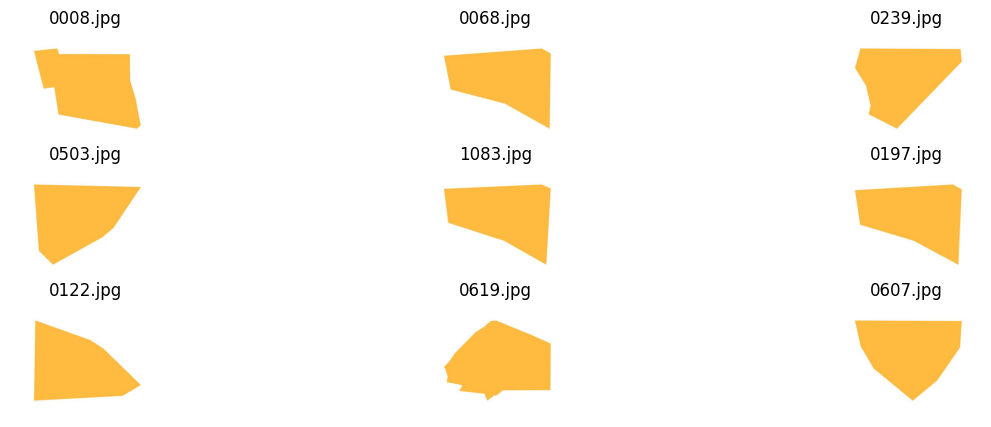


Displaying images of relevant layouts for dim2/dim1 ratio:


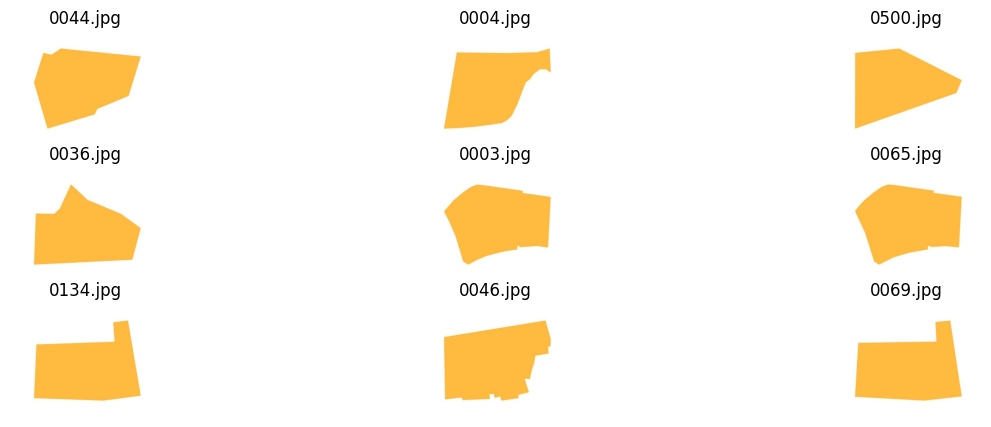

In [10]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Load data from CSV file
data = pd.read_csv("features_with_labels.csv")

# Placeholder function to preprocess data (replace with your actual preprocessing logic)
def preprocess_data(data):
    # Placeholder preprocessing steps (you may need to adapt this based on your actual data)
    data['dim1_dim2_ratio'] = data['dim1 of tfb'] / data['dim2 of tfb']
    X = data[['dim1_dim2_ratio', 'Complexity', 'Ratio_Area_to_Bounding_Rect']].values
    return X

# Preprocess data
X = preprocess_data(data)

# Function to predict relevant layout designs based on parameters
def predict_layouts(dim1_dim2_ratio, complexity, ratio_area_to_bounding_rect, num_neighbors=9):
    input_params = np.array([[dim1_dim2_ratio, complexity, ratio_area_to_bounding_rect]])
    
    # Initialize and fit nearest neighbors model
    nn_model = NearestNeighbors(n_neighbors=num_neighbors)
    nn_model.fit(X)
    
    # Find nearest neighbors based on input parameters
    distances, indices = nn_model.kneighbors(input_params)
    
    # Retrieve and return relevant layouts
    relevant_layouts = data.iloc[indices[0]]
    relevant_layouts = relevant_layouts[relevant_layouts['Complexity'] == complexity]
    
    return relevant_layouts

# Function to display images of relevant layouts
def display_layout_images(relevant_layouts, image_folder, nrows=3, ncols=3):
    """
    Display images of relevant layouts in a grid.

    Args:
        relevant_layouts (pd.DataFrame): DataFrame containing relevant layouts.
        image_folder (str): Folder containing the images.
        nrows (int): Number of rows in the grid.
        ncols (int): Number of columns in the grid.

    Returns:
        None: This function does not return any value. It only displays the images.
    """
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(relevant_layouts['Image Number']):
        img_path = os.path.join(image_folder, filename)
        img = mpimg.imread(img_path)
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')
    plt.show()


dim1 = float(input("Enter the dim1 of tfb: "))  # Example dim1
dim2 = float(input("Enter the dim2 of tfb: "))  # Example dim2
complexity = int(input("Enter the complexity: "))  # Example complexity
cont_area = float(input("Enter the Cont_Area: "))  # Example cont_area

# Calculate both ratios
dim1_dim2_ratio = dim1 / dim2
dim2_dim1_ratio = dim2 / dim1

# Calculate ratio_area_to_bounding_rect
ratio_area_to_bounding_rect = cont_area / (dim1 * dim2)  # Example ratio_area_to_bounding_rect

# Example usage for dim1/dim2 ratio
relevant_layouts_dim1_dim2 = predict_layouts(dim1_dim2_ratio, complexity, ratio_area_to_bounding_rect)

# Example usage for dim2/dim1 ratio
relevant_layouts_dim2_dim1 = predict_layouts(dim2_dim1_ratio, complexity, ratio_area_to_bounding_rect)

# Print results for both ratios
print("Relevant Layouts for dim1/dim2 ratio:")
print(relevant_layouts_dim1_dim2)

print("\nRelevant Layouts for dim2/dim1 ratio:")
print(relevant_layouts_dim2_dim1)

# Display images of relevant layouts for dim1/dim2 ratio
image_folder = "E7-unique-images"
print("\nDisplaying images of relevant layouts for dim1/dim2 ratio:")
display_layout_images(relevant_layouts_dim1_dim2, image_folder)

# Display images of relevant layouts for dim2/dim1 ratio
print("\nDisplaying images of relevant layouts for dim2/dim1 ratio:")
display_layout_images(relevant_layouts_dim2_dim1, image_folder)
